# Предсказание цен на дома с помощью байесовского моделирования

In [1]:
import pandas as pd
import scipy.stats as st
from itertools import product
import numpy as np
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## 1. Preprocessing

<AxesSubplot:>

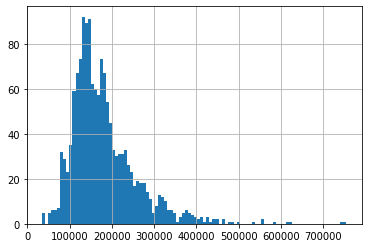

In [3]:
df.SalePrice.hist(bins=100)

<AxesSubplot:>

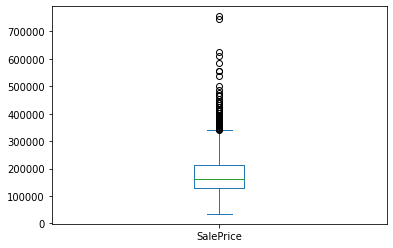

In [4]:
df.SalePrice.plot.box()

Я бы не сказал, что квартиры с высокой стоимостью - это выбросы, несмотря на то, что плотбокс говорит об обратном. Поэтому оставлю их в данных.

In [5]:
y = df.SalePrice.values
df.drop(['Id', 'SalePrice'], inplace=True, axis=1)

### 1.1. Fill missing values

In [6]:
nans = df.isna().sum()
nans[nans != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Удалим все колонки, в которых пропущенных значений больше трети от всех данных. В остальных случаях заменим пропущенные значения медианным значением для числовых признаков и наиболее вероятным - для категориальных.

In [7]:
df.drop(nans[nans > 500].index, inplace=True, axis=1)
df.shape

(1460, 74)

In [8]:
def fill_nans(col):
    if df[col].dtype == 'O':
        value = df[col].value_counts().index[0]
    else:
        value = df[col].median()
    df[col].fillna(value, inplace=True)

In [9]:
for col in nans[nans <= 500].index:
    fill_nans(col)

### 1.2. Chi-square test

При использовании байесовского моделирования критичным моментом является зависимость признаков. Избавимся от высокозависимых признаков.
Для категориальных переменных используем статистику хи-квадрат, для числовых - корреляцию.

In [10]:
number_features = df.select_dtypes(include='number').columns.values
categorical_features = df.select_dtypes(exclude='number').columns.values

In [11]:
categorical_pairs = list(product(categorical_features, categorical_features))

In [12]:
result = []
for left, right in categorical_pairs:
    result.append(
        [left, right, list(st.chi2_contingency(pd.crosstab(df[left], df[right])))[1]]
    )

In [13]:
chi_test_df = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'])
chi_test_df = chi_test_df.pivot(index='var1', columns='var2', values='coeff')
chi_test_df.head()

var2,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,...,MSZoning,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
var1,,,,,,,,,,,,,,,,,,,,,
BldgType,0.000000e+00,1.045284e-01,1.329942e-03,9.644209e-10,2.922600e-01,1.211261e-23,3.533808e-26,0.000424,2.143323e-18,5.393590e-06,...,1.747029e-38,4.966499e-06,1.312756e-173,2.898240e-12,2.604886e-01,3.143538e-02,3.332217e-23,3.697420e-07,0.000163,0.995462
BsmtCond,1.045284e-01,0.000000e+00,7.686917e-03,4.195093e-07,2.502275e-02,3.980783e-32,3.361670e-18,0.197262,5.642101e-01,1.466684e-160,...,2.408240e-06,1.068283e-01,1.858132e-05,3.367589e-11,1.433841e-01,3.247403e-02,5.090615e-03,2.308496e-04,0.918765,0.993781
BsmtExposure,1.329942e-03,7.686917e-03,0.000000e+00,5.935440e-34,1.037751e-04,4.574545e-35,1.384481e-03,0.004154,7.382517e-01,1.938164e-03,...,4.541822e-04,1.531087e-12,4.132654e-45,2.967119e-03,2.204261e-14,7.578232e-13,1.995141e-06,2.299494e-07,0.001770,0.924655
BsmtFinType1,9.644209e-10,4.195093e-07,5.935440e-34,0.000000e+00,6.659437e-61,1.696923e-93,4.335349e-12,0.066369,3.071869e-01,7.543981e-10,...,6.792292e-16,3.574544e-31,1.703639e-101,2.515353e-18,4.332779e-02,1.389657e-02,8.895452e-10,5.359374e-09,0.715059,0.777318
BsmtFinType2,2.922600e-01,2.502275e-02,1.037751e-04,6.659437e-61,0.000000e+00,3.033808e-06,2.751429e-01,0.392032,2.681322e-01,9.960953e-01,...,1.091351e-01,1.688320e-02,1.281864e-16,3.048874e-01,6.105178e-12,3.454827e-05,4.649738e-01,5.293634e-03,0.000558,0.000087


In [14]:
alpha = 0.05

upper = np.triu(chi_test_df.values)
rows, cols = np.where((upper != 0) & (upper < alpha))

In [15]:
to_drop = chi_test_df.columns[np.unique(cols)]
to_drop.shape

(36,)

Среди категориальных признаков почти все зависимы, оставляем только 2 из них.

In [16]:
categorical_features_staied = list(set(categorical_features).difference(set(to_drop)))

In [17]:
df.drop(to_drop, inplace=True, axis=1)

### 1.3. Correlation

In [18]:
corr = df[number_features].corr().abs()

In [19]:
mat = corr.values
rows, cols = np.where((mat != 1) & (mat > 0.95))

In [20]:
np.unique(cols).shape

(0,)

### 1.4. Feature encoding

Заменим категориальные значения для двух признаков числовым.

In [21]:
encoder = TargetEncoder(min_samples_leaf=3, smoothing=0.5)
encoder.fit(df[categorical_features_staied], y)

TargetEncoder(cols=['BsmtCond', 'BldgType'], min_samples_leaf=3, smoothing=0.5)

In [22]:
df[categorical_features_staied] = encoder.transform(df[categorical_features_staied])

In [23]:
X = df.values

In [24]:
# scaler = StandardScaler()
# scaler.fit(X)

In [49]:
# X_std = scaler.transform(X)

### 1.5. Train-test split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## 2. Baseline

В качестве бейслайна попробуем обычную регрессию.

In [26]:
base = LinearRegression()
base.fit(X_train, y_train)

LinearRegression()

In [27]:
base.score(X_test, y_test)

0.8415386707016772

In [28]:
mean_squared_error(y_test, base.predict(X_test), squared=False)

31292.65097582908

На каггле в этом задании используют логарифм от таргета

In [29]:
mean_squared_error(np.log(y_test), np.log(base.predict(X_test)), squared=False)

0.14737012533080102

## 3. Bayesian method

Здесь я дополнительно отбираю только часть признаков, т.к. семплирование занимает слишком много ресурсов и по большей части признаков модель не сходится.

In [31]:
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_regression

In [32]:
selector = SelectFromModel(base)

In [33]:
selector.fit(X_train, y_train)

SelectFromModel(estimator=LinearRegression())

In [34]:
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

In [35]:
X_train_sel.shape

(1168, 11)

In [37]:
cols = ['x' + str(i) for i in range(X_train_sel.shape[1])]
cols

['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']

Важный момент - нужно так же нормировать трагет, иначе производные почти сразу зануляются.

In [38]:
with pm.Model() as linear_model:
    data = pm.Data("data", X_train_sel)
    pm.glm.GLM(x=data, y=np.log(y_train), labels=list(cols))
    trace = pm.sample(1000, tune=1000, init="adapt_diag")

/Users/bryl/projects/venv/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x10, x9, x8, x7, x6, x5, x4, x3, x2, x1, x0, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


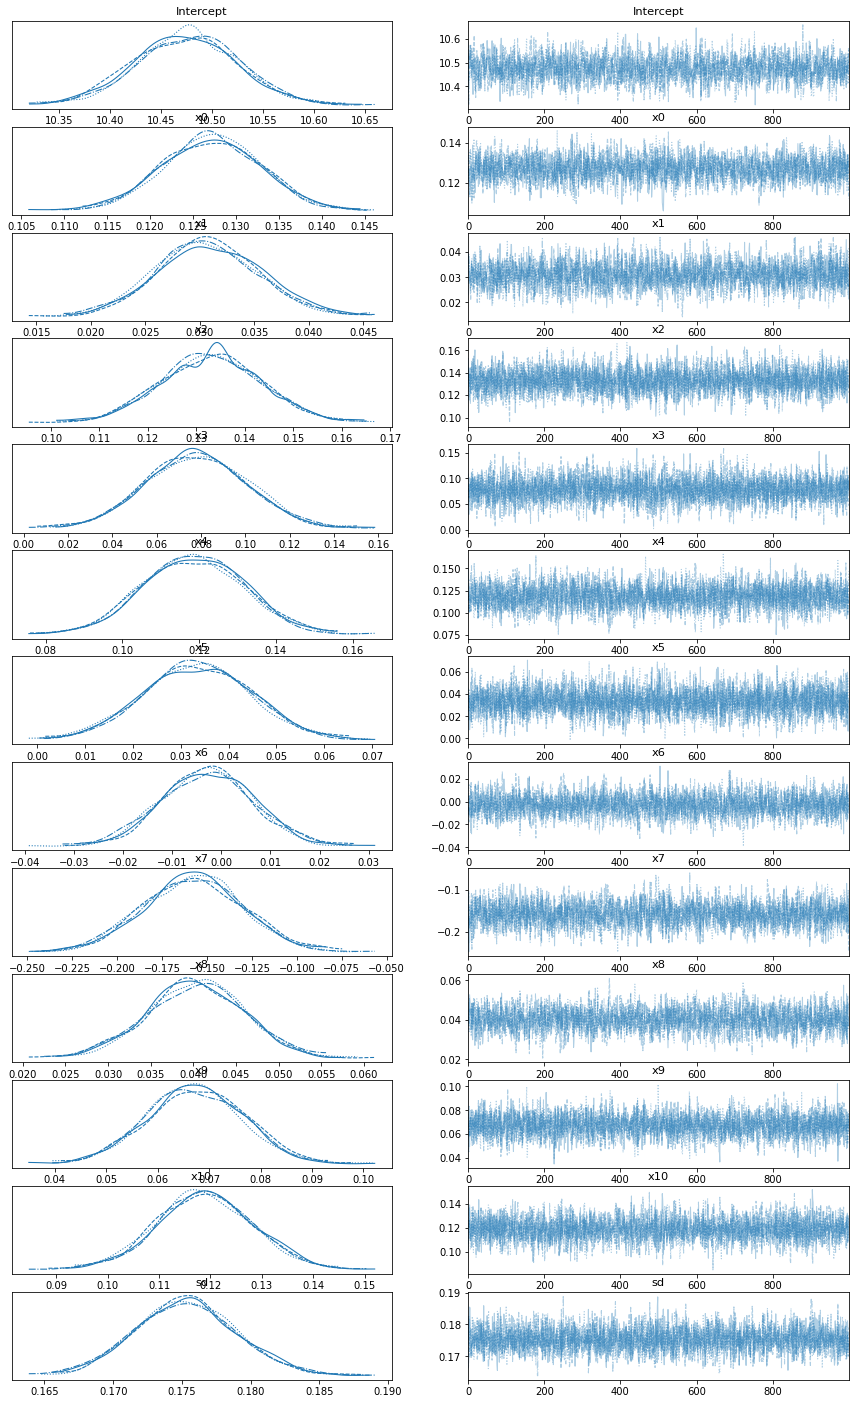

In [39]:
with linear_model:
    az.plot_trace(trace, figsize=(15,25))
    plt.show()

Видно, что в левой части графика нет никаких странных закономерностей, признаки распределены нормально. В правой части графика так же видно, что случайные значения отклоняются более менее равномерно от среднего. Это говорит о том, что модель удалась.

In [42]:
with linear_model:
    pm.set_data({"data": X_test_sel})
    y_pred = pm.sample_posterior_predictive(trace)

In [51]:
mean_squared_error(np.log(y_test), y_pred['y'].mean(axis=0), squared=True)

0.025372227156654232

Так же ошибка на порядок меньше, чем при бейслайне. При этом на меньшем количестве признаков (бейслайн с отобранными признаками показывает еще более худшие результаты)